# Parameterized level set optimization of a y-branch

> **Note: the cost of running the entire notebook is higher than 1 FlexCredit.**

This notebook demonstrates how to set up and run a parameterized level set-based optimization of a Y-branch. In this approach, we use `jax` to generate a level set surface $\phi(\rho)$ given a set of control knots $\rho$. The permittivity distribution is then obtained implicitly from the zero level set isocontour. Details about the level set method can be found [here](https://doi.org/10.1016/S0045-7825(02)00559-5). Minimum gap and curvature penalty terms are introduced in the optimization to control the minimum feature size, hence improving device fabrication. In addition, we show how to tailor the initial level set function to a starting geometry, which is helpful to further optimize a device obtained by conventional design.

You can also find some interesting adjoint functionalities for shape optimization in [Inverse design optimization of a waveguide taper](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/) and [Adjoint-based shape optimization of a waveguide bend](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin8WaveguideBend/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/tidy3d/learning-center/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

<img src="img/y_branch_level_set.png" alt="Y-branch Level Set Structure"  width="600"/>

Let's start by importing the Python libraries used throughout this notebook.

In [1]:
# Standard python imports.
from typing import List
import numpy as np
import matplotlib.pylab as plt

# Import jax to be able to use automatic differentiation.
import jax.numpy as jnp
from jax import value_and_grad
import optax
import pickle
import gdstk

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

# Import the components we need from the adjoint plugin.
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run

plt.rcParams['font.size'] = '12'

## Y-branch Inverse Design Configuration

The y-branch splits the power from an input waveguide into two other output waveguides. Here, we are considering a gap of 0.3 $\mu m$ between the output waveguides for illustration purposes. However, when considering the design of a practical device, this value can be smaller. S-bends are included to keep the output waveguides apart each other to prevent mode coupling.

Next, you can set the y-branch geometry and the inverse design parameters.

In [2]:
# Geometric parameters.
y_width = 1.7  # Y-branch maximum width (um).
y_length = 1.7  # Y-branch maximum length (um).
w_thick = 0.22  # Waveguide thickness (um).
w_width = 0.5  # Waveguide width (um).
w_length = 1.0  # Input output waveguide length (um).
w_gap = 0.3  # Gap between the output waveguides (um).
bend_length = 3  # Output waveguide bend length (um).
bend_offset = 0.5  # Offset between output bends (um).

# Material.
nSi = 3.48  # Silicon refractive index.

# Inverse design set up parameters.
grid_size = 0.016  # Simulation grid size on design region (um).
ls_grid_size = 0.004  # Discretization size of the level set function (um).
ls_down_sample = 20  # The spacing between the level set control knots is given by ls_grid_size*ls_down_sample.
fom_name_1 = "fom_field1"  # Name of the monitor used to compute the objective function.
min_feature_size = 0.14  # Minimum fabrication feature size (um).
gap_par = 1.0  # Parameter to minimum gap fabrication constraint.
curve_par = 1.5  # Parameter of minimum curvature fabrication constraint.

# Optimizer parameters.
iterations = 100  # Maximum number of iterations in optimization.
learning_rate = 0.03

# Simulation wavelength.
wl = 1.55  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

From the parameters defined before, a lot of variables are computed and used to set up the optimization.

In [3]:
# Minimum and maximum values for the permittivities.
eps_max = nSi ** 2
eps_min = 1.0

# Material definition.
mat_si = td.Medium(permittivity=eps_max)  # Waveguide material.

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-13

# Computational domain size.
pml_spacing = 0.6 * wl
size_x = 2 * w_length + y_length + bend_length
size_y = w_gap + 2 * (bend_offset + w_width + pml_spacing)
size_z = w_thick + 2 * pml_spacing
eff_inf = 10

# Source and monitor positions.
mon_w = 3 * w_width
mon_h = 5 * w_thick

# Separation between the level set control knots.
rho_size = ls_down_sample * ls_grid_size

# Number of points on the parameter grid (rho) and level set grid (phi)
nx_rho = int(y_length / rho_size) + 1
ny_rho = int(y_width / rho_size / 2) + 1
nx_phi = int(y_length / ls_grid_size) + 1
ny_phi = int(y_width / ls_grid_size / 2) + 1
npar = nx_rho * ny_rho
ny_rho *= 2
ny_phi *= 2

# Design region size
dr_size_x = (nx_phi - 1) * ls_grid_size
dr_size_y = (ny_phi - 1) * ls_grid_size
dr_center_x = -size_x / 2 + w_length + dr_size_x / 2

# xy coordinates of the parameter and level set grids.
x_rho = np.linspace(dr_center_x - dr_size_x / 2, dr_center_x + dr_size_x / 2, nx_rho)
x_phi = np.linspace(dr_center_x - dr_size_x / 2, dr_center_x + dr_size_x / 2, nx_phi)
y_rho = np.linspace(-dr_size_y / 2, dr_size_y / 2, ny_rho)
y_phi = np.linspace(-dr_size_y / 2, dr_size_y / 2, ny_phi)

## Level Set Functions

A level set function is a continuous function over space, which defines a shape where the function crosses a threshold value, usually equal to zero. We are using `jax` to implement a parameterized level set function so the gradients can back-propagate from the permittivity distribution defined by the zero level set isocontour to the control knots given by the optimization algorithm. The level set surface is generated by globally supported Gaussian radial basis functions. Other types of radial basis functions can also be used in replacement of the Gaussian one employed here, such as [multiquadric splines](https://onlinelibrary.wiley.com/doi/10.1002/nme.1536) or [b-splines](https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-5-7060&id=427821).

In [4]:
class LevelSetInterp(object):
    """This class implements the level set surface using Gaussian radial basis functions."""
    def __init__(
        self,
        x0: jnp.ndarray = None,
        y0: jnp.ndarray = None,
        z0: jnp.ndarray = None,
        sigma: float = None,
    ):
        # Input data.
        x, y = jnp.meshgrid(y0, x0)
        xy0 = jnp.column_stack((x.reshape(-1), y.reshape(-1)))
        self.xy0 = xy0
        self.z0 = z0
        self.sig = sigma
        # Builds the level set interpolation model.
        gauss_kernel = self.gaussian(self.xy0, self.xy0)
        self.model = jnp.dot(jnp.linalg.inv(gauss_kernel), self.z0)

    def gaussian(self, xyi, xyj):
        dist = jnp.sqrt(
            (xyi[:, 1].reshape(-1, 1) - xyj[:, 1].reshape(1, -1)) ** 2
            + (xyi[:, 0].reshape(-1, 1) - xyj[:, 0].reshape(1, -1)) ** 2
        )
        return jnp.exp(-(dist ** 2) / (2 * self.sig ** 2))

    def get_ls(self, x1, y1):
        xx, yy = jnp.meshgrid(y1, x1)
        xy1 = jnp.column_stack((xx.reshape(-1), yy.reshape(-1)))
        ls = self.gaussian(self.xy0, xy1).T @ self.model
        return ls


# Function to plot the level set surface.
def plot_level_set(x0, y0, rho, x1, y1, phi):
    y, x = np.meshgrid(y0, x0)
    yy, xx = np.meshgrid(y1, x1)
    
    fig = plt.figure(figsize=(12, 6), tight_layout=True)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.view_init(elev=45, azim=-45, roll=0)
    ax1.plot_surface(xx, yy, phi, cmap="RdBu", alpha=0.8)
    ax1.contourf(xx, yy, phi, levels=[np.amin(phi), 0],
                 zdir ='z',
                 offset = 0,
                 colors=["k","w"], alpha=0.5)
    ax1.contour3D(xx, yy, phi, 1, cmap="binary", linewidths=[2])
    ax1.scatter(x, y, rho, color="black", linewidth=1.0)
    ax1.set_title("Level set surface")
    ax1.set_xlabel("x ($\mu m$)")
    ax1.set_ylabel("y ($\mu m$)")
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('w')
    ax1.yaxis.pane.set_edgecolor('w')
    ax1.zaxis.pane.set_edgecolor('w')
    
    ax2 = fig.add_subplot(1, 2, 2)    
    ax2.contourf(xx, yy, phi, levels=[0, np.amax(phi)], colors=[[0,0,0]])
    ax2.set_title("Zero level set contour")
    ax2.set_xlabel("x ($\mu m$)")
    ax2.set_ylabel("y ($\mu m$)")
    ax2.set_aspect("equal")
    plt.show() 


To map the permittivities to the zero-level set contour and obtain continuous derivatives, we use a hyperbolic tangent function as an approximation to a Heaviside function. Other smooth functions, such as sigmoid and arctangent, can also be employed. As discussed [here](https://www.sciencedirect.com/science/article/pii/S0009250917303986), the difference on computed interface using different functions will decrease when reducing the mesh size.

In [5]:
def mirror_param(design_param):
    param = jnp.array(design_param).reshape((nx_rho, int(ny_rho / 2)))
    return jnp.concatenate((jnp.fliplr(jnp.copy(param)), param), axis=1).flatten()

def get_eps(design_param, sharpness = 10, plot_levelset=False) -> np.ndarray:
    """Returns the permittivities defined by the zero level set isocontour"""
    phi_model = LevelSetInterp(x0=x_rho, y0=y_rho, z0=design_param, sigma=rho_size)
    phi = phi_model.get_ls(x1=x_phi, y1=y_phi)

    # Calculates the permittivities from the level set surface.
    eps_phi = 0.5 * (jnp.tanh(sharpness * phi) + 1)
    eps = eps_min + (eps_max - eps_min) * eps_phi
    eps = jnp.maximum(eps, eps_min)
    eps = jnp.minimum(eps, eps_max)

    # Reshapes the design parameters into a 2D matrix.
    eps = jnp.reshape(eps, (nx_phi, ny_phi))

    # Plots the level set surface.
    if plot_levelset:
        rho = np.reshape(design_param, (nx_rho, ny_rho))
        phi = np.reshape(phi, (nx_phi, ny_phi))
        plot_level_set(x0=x_rho, y0=y_rho, rho=rho, x1=x_phi, y1=y_phi, phi=phi)

    return eps

In the next function, the permittivity values are used to build a [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html) within the design region.

In [6]:
def update_design(eps, unfold=False) -> List[tda.JaxStructure]:
    # Reflects the structure about the x-axis.
    eps_val = jnp.array(eps).reshape((nx_phi, ny_phi, 1, 1))
    coords_x = [(dr_center_x - dr_size_x / 2) + ix * ls_grid_size for ix in range(nx_phi)]

    if unfold == False:
        # Creation of a JaxCustomMedium using the values of the design parameters.
        coords_yp = [0 + iy * ls_grid_size for iy in range(int(ny_phi / 2))]
        coords = dict(x=coords_x, y=coords_yp, z=[0], f=[freq])
        eps_jax = {
            f"eps_{dim}{dim}": tda.JaxDataArray(values=eps_val[:,int(ny_phi / 2):, :, :], coords=coords)
            for dim in "xyz"
        }
        eps_dataset = tda.JaxPermittivityDataset(**eps_jax)
        eps_medium = tda.JaxCustomMedium(eps_dataset=eps_dataset, interp_method="linear")
        box = tda.JaxBox(center=(dr_center_x, dr_size_y / 4, 0), size=(dr_size_x, dr_size_y / 2, w_thick))
        structure = [tda.JaxStructure(geometry=box, medium=eps_medium)]

    else:
        # Creation of a CustomMedium using the values of the design parameters.
        coords_y = [-dr_size_y / 2 + iy * ls_grid_size for iy in range(ny_phi)]
        coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq])
        eps_jax = {
            f"eps_{dim}{dim}": tda.JaxDataArray(values=eps_val, coords=coords)
            for dim in "xyz"
        }
        eps_dataset = tda.JaxPermittivityDataset(**eps_jax)
        eps_medium = tda.JaxCustomMedium(
            eps_dataset=eps_dataset, interp_method="linear"
        )
        box = tda.JaxBox(
            center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick)
        )
        structure = [tda.JaxStructure(geometry=box, medium=eps_medium)]
    return structure

## Initial Structure

We built an initial y-brach structure containing some holes and different gap sizes to demonstrate how the design evolves under fabrication constraints. We define this structure using a `PolySlab` object and then translate it into a permittivity grid of the same size as the one used to define the level set function. The holes are introduced in the polygon using the [ClipOperation](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ClipOperation.html) object.

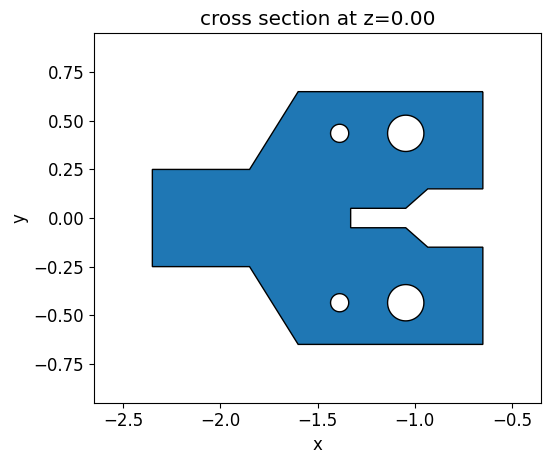

In [7]:
vertices = np.array(
    [
        (-size_x / 2 + w_length, w_width / 2),
        (-size_x / 2 + w_length + 0.5, w_width / 2),
        (-size_x / 2 + w_length + 0.75,  w_gap / 2 + w_width),                
        (-size_x / 2 + w_length + dr_size_x, w_gap / 2 + w_width),
        (-size_x / 2 + w_length + dr_size_x, w_gap / 2),
        (-size_x / 2 + w_length + 2.5*dr_size_x / 3, w_gap / 2),        
        (-size_x / 2 + w_length + 2.3*dr_size_x / 3, w_gap / 6), 
        (-size_x / 2 + w_length + 1.8*dr_size_x / 3, w_gap / 6), 
        (-size_x / 2 + w_length + 1.8*dr_size_x / 3, -w_gap / 6),                               
        (-size_x / 2 + w_length + 2.3*dr_size_x / 3, -w_gap / 6),       
        (-size_x / 2 + w_length + 2.5*dr_size_x / 3, -w_gap / 2),                 
        (-size_x / 2 + w_length + dr_size_x, -w_gap / 2),                
        (-size_x / 2 + w_length + dr_size_x, -w_gap / 2 - w_width),
        (-size_x / 2 + w_length + 0.75, -w_gap / 2 - w_width),                
        (-size_x / 2 + w_length + 0.5, -w_width / 2),        
        (-size_x / 2 + w_length, -w_width / 2),
    ]
)

y_poly = td.PolySlab(
    vertices=vertices, axis=2, slab_bounds=(-w_thick / 2, w_thick / 2)
)
y_hole1 = td.Cylinder(center=(-size_x / 2 + w_length + 1.7*dr_size_x / 3, w_gap / 2 + w_width / 1.75, 0), 
                   radius=min_feature_size/3, length=w_thick, axis=2)
y_hole2 = td.Cylinder(center=(-size_x / 2 + w_length + 1.7*dr_size_x / 3, -w_gap / 2 - w_width / 1.75, 0), 
                   radius=min_feature_size/3, length=w_thick, axis=2)
y_hole3 = td.Cylinder(center=(-size_x / 2 + w_length + 2.3*dr_size_x / 3, w_gap / 2 + w_width / 1.75, 0), 
                   radius=min_feature_size/1.5, length=w_thick, axis=2)
y_hole4 = td.Cylinder(center=(-size_x / 2 + w_length + 2.3*dr_size_x / 3, -w_gap / 2 - w_width / 1.75, 0), 
                   radius=min_feature_size/1.5, length=w_thick, axis=2)
init_design = td.ClipOperation(operation="difference", geometry_a=y_poly, geometry_b=y_hole1)
init_design = td.ClipOperation(operation="difference", geometry_a=init_design, geometry_b=y_hole2)
init_design = td.ClipOperation(operation="difference", geometry_a=init_design, geometry_b=y_hole3)
init_design = td.ClipOperation(operation="difference", geometry_a=init_design, geometry_b=y_hole4)

init_eps = init_design.inside_meshgrid(x=x_phi, y=y_phi, z=np.zeros((1)))
init_eps = np.squeeze(init_eps) * eps_max

init_design.plot(z=0)
plt.show()

Then an objective function which compares the initial structure and the permittivity distribution generated by the level set zero contour is defined. 

In [8]:
# Figure of Merit (FOM) calculation.
def fom_eps(eps_ref: jnp.ndarray, eps: jnp.ndarray) -> float:
    """Calculate the L2 norm between eps_ref and eps."""
    return jnp.mean(jnp.abs(eps_ref - eps) ** 2)

# Objective function to be passed to the optimization algorithm.
def obj_eps(design_param, eps_ref) -> float:
    param = mirror_param(design_param)
    eps = get_eps(param)
    return fom_eps(eps_ref, eps)

# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad_eps = value_and_grad(obj_eps)

So, the initial control knots are obtained after fitting the initial structure using the level set function. This is accomplished by minimizing the L2 norm between the reference and the level set generated permittivities. The fitting is performed by the Adam optimizer from the [Optax](https://optax.readthedocs.io/en/latest/index.html) library. 

In [9]:
# Initialize adam optimizer with starting parameters.
start_par = np.zeros((npar))
optimizer = optax.adam(learning_rate=learning_rate*10)
opt_state = optimizer.init(start_par)

# Store history
params_eps = start_par
obj_eps = []
params_history_eps = [start_par]

for i in range(50):

    # Compute gradient and current objective funciton value.
    value, gradient = obj_grad_eps(params_eps, init_eps)

    # outputs
    print(f"Step = {i + 1}")
    print(f"\tobj_eps = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # Compute and apply updates to the optimizer based on gradient.
    updates, opt_state = optimizer.update(gradient, opt_state, params_eps)
    params_eps = optax.apply_updates(params_eps, updates)

    # Save history.
    obj_eps.append(value)
    params_history_eps.append(params_eps)

# Gets the final parameters and the objective values history.
init_rho = params_history_eps[-1]
obj_vals_eps = np.array(obj_eps)

Step = 1
	obj_eps = 3.6687e+01
	grad_norm = 4.2700e+01
Step = 2
	obj_eps = 3.6697e+00
	grad_norm = 3.2333e+00
Step = 3
	obj_eps = 2.4378e+00
	grad_norm = 1.8882e+00
Step = 4
	obj_eps = 2.1341e+00
	grad_norm = 1.6315e+00
Step = 5
	obj_eps = 1.9714e+00
	grad_norm = 1.3847e+00
Step = 6
	obj_eps = 1.7556e+00
	grad_norm = 1.1197e+00
Step = 7
	obj_eps = 1.5511e+00
	grad_norm = 8.4940e-01
Step = 8
	obj_eps = 1.4104e+00
	grad_norm = 7.0775e-01
Step = 9
	obj_eps = 1.3275e+00
	grad_norm = 6.5512e-01
Step = 10
	obj_eps = 1.2859e+00
	grad_norm = 6.4978e-01
Step = 11
	obj_eps = 1.2632e+00
	grad_norm = 6.6684e-01
Step = 12
	obj_eps = 1.2370e+00
	grad_norm = 6.5305e-01
Step = 13
	obj_eps = 1.2016e+00
	grad_norm = 6.0398e-01
Step = 14
	obj_eps = 1.1636e+00
	grad_norm = 5.5132e-01
Step = 15
	obj_eps = 1.1264e+00
	grad_norm = 5.0319e-01
Step = 16
	obj_eps = 1.0915e+00
	grad_norm = 4.5089e-01
Step = 17
	obj_eps = 1.0631e+00
	grad_norm = 4.0192e-01
Step = 18
	obj_eps = 1.0442e+00
	grad_norm = 3.7285e-01
S

The following graph shows the evolution of the objective function along the initial structure fitting.

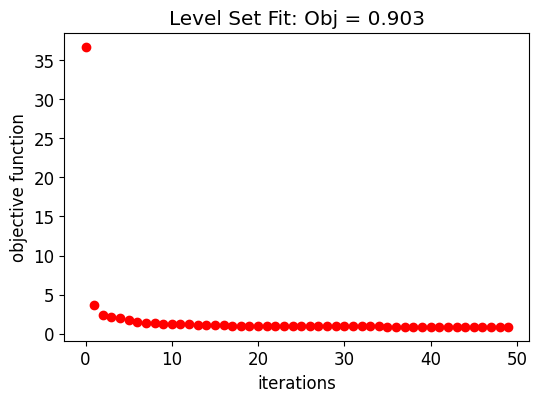

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals_eps, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Level Set Fit: Obj = {obj_vals_eps[-1]:.3f}")
plt.show()

Here, one can see the initial parameters, which are the control knots defining the level set surface. The geometry of the structure will change as the zero isocontour evolves. The width of the Gaussian radial basis functions and the spacing of the control knots impact the accuracy and the smoothness of the initial zero-level set contour.

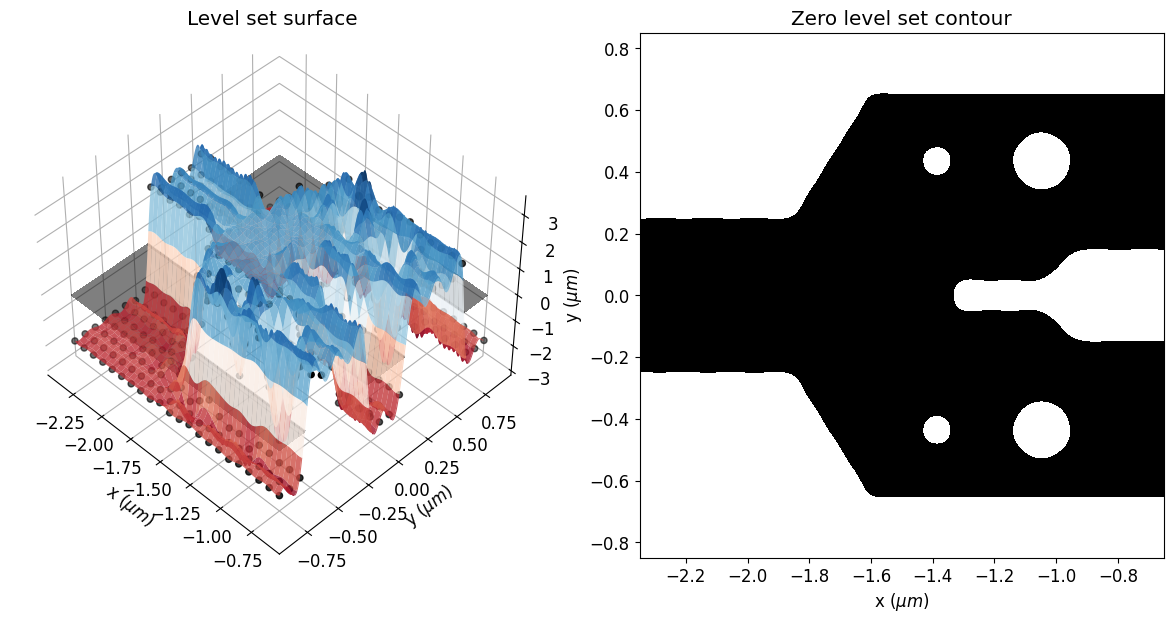

In [11]:
eps_fit = get_eps(mirror_param(init_rho), plot_levelset=True)

## Inverse Design Optimization Set Up

Next, we will write a function to return the `JaxSimulation` object. Note that we are using a `MeshOverrideStructure` to obtain a uniform mesh over the design region.

The elements that do not change along the optimization are defined first.

In [12]:
# Input waveguide.
wg_input = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-eff_inf, -w_width / 2, -w_thick / 2),
        rmax=(-size_x / 2 + w_length + grid_size, w_width / 2, w_thick / 2),
    ),
    medium=mat_si,
)

# Output bends.
x_start = -size_x / 2 + w_length + dr_size_x - grid_size # x-coordinate of the starting point of the waveguide bends.
x = np.linspace(
    x_start, x_start + bend_length, 100
)  # x-coordinates of the top edge vertices.
y = (
    (x - x_start) * bend_offset / bend_length
    - bend_offset * np.sin(2 * np.pi * (x - x_start) / bend_length) / (np.pi * 2)
    + (w_gap + w_width) / 2
)  # y coordinates of the top edge vertices

# adding the last point to include the straight waveguide at the output
x = np.append(x, eff_inf)
y = np.append(y, y[-1])

# add path to the cell
cell = gdstk.Cell("bend")
cell.add(gdstk.FlexPath(x + 1j * y, w_width, layer=1, datatype=0))  # Top waveguide bend.
cell.add(gdstk.FlexPath(x - 1j * y, w_width, layer=1, datatype=0))  # Bottom waveguide bend.

# Define top waveguide bend structure.
wg_bend_top = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(-w_thick/2, w_thick/2),
    )[1],
    medium=mat_si
)

# Define bottom waveguide bend structure.
wg_bend_bot = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(-w_thick/2, w_thick/2),
    )[0],
    medium=mat_si
)

Monitors used to get simulation data.

In [13]:
# Input mode source.
mode_spec = td.ModeSpec(num_modes=1, target_neff=nSi)
source = td.ModeSource(
    center=(-size_x / 2 + 0.15 * wl, 0, 0),
    size=(0, mon_w, mon_h),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# Monitor where we will compute the objective function from.
fom_monitor_1 = td.ModeMonitor(
    center=[size_x / 2 - 0.25 * wl, (w_gap + w_width) / 2 + bend_offset, 0],
    size=[0, mon_w, mon_h],
    freqs=[freq],
    mode_spec=mode_spec,
    name=fom_name_1,
)

### Monitors used only to visualize the initial and final y-branch results.
# Field monitors to visualize the final fields.
field_xy = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="field_xy",
)

# Monitor where we will compute the objective function from.
fom_final_1 = td.ModeMonitor(
    center=[size_x / 2 - 0.25 * wl, (w_gap + w_width) / 2 + bend_offset, 0],
    size=[0, mon_w, mon_h],
    freqs=freqs,
    mode_spec=mode_spec,
    name="out_1",
)

And then the `JaxSimulation` is built.

In [14]:
def make_adjoint_sim(design_param, unfold=False) -> tda.JaxSimulation:
    # Builds the design region from the design parameters.
    eps = get_eps(design_param)
    design_structure = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick)
        ),
        dl=[grid_size, grid_size, grid_size],
        enforce=True,
    )

    return tda.JaxSimulation(
        size=[size_x, size_y, size_z],
        center=[0, 0, 0],
        grid_spec=td.GridSpec.auto(
            wavelength=wl_max,
            min_steps_per_wvl=15,
            override_structures=[adjoint_dr_mesh],
        ),
        symmetry=(0, -1, 1),
        structures=[wg_input, wg_bend_top, wg_bend_bot],
        input_structures=design_structure,
        sources=[source],
        monitors=[],
        output_monitors=[fom_monitor_1],
        run_time=run_time,
        subpixel=True,
    )

Let's visualize the simulation setup and verify if all the elements are in their correct places. Differently from the density-based methods, we will start from a fully binarized structure.

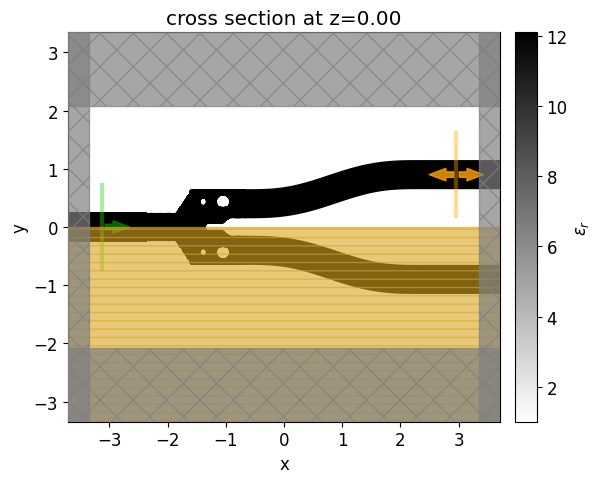

In [15]:
init_design = make_adjoint_sim(mirror_param(init_rho), unfold=True)

fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 5))
init_design.plot_eps(z=0, ax=ax1)
plt.show()

Now, we will run a simulation to see how this non-optimized y-branch performs.

In [16]:
sim_init = init_design.to_simulation()[0].copy(
    update=dict(monitors=(field_xy, fom_final_1))
)
sim_data = web.run(sim_init, task_name="initial y-branch")

16:07:21 -03 Created task 'initial y-branch' with task_id                       
             'fdve-4349b686-652c-4c9b-b89e-f878d95926c8' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=885683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=783743;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\taskId]8;;\]8;id=885683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\=]8;;\]8;id=550260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\fdve]8;;\]8;id=885683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\-4349b686-652]8;;\
             ]8;id=885683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\c-4c9b-b89e-f878d95926c8']8;;\.

Output()

16:07:28 -03 status = queued

Output()

16:07:39 -03 status = preprocess

16:07:48 -03 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

16:07:49 -03 running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:08:02 -03 early shutoff detected at 88%, exiting.

16:08:03 -03 status = postprocess

Output()

16:08:09 -03 status = success

             View simulation result at                                          
             ]8;id=38555;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=915308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\taskId]8;;\]8;id=38555;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\=]8;;\]8;id=126170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\fdve]8;;\]8;id=38555;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\-4349b686-652]8;;\
             ]8;id=38555;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4349b686-652c-4c9b-b89e-f878d95926c8\c-4c9b-b89e-f878d95926c8']8;;\.

Output()

16:08:17 -03 loading simulation from simulation_data.hdf5

The coupling efficiencies of the non-optimized y-branch outputs are below -6 dB at 1.55 $\mu m$, and much of the input power is reflected.

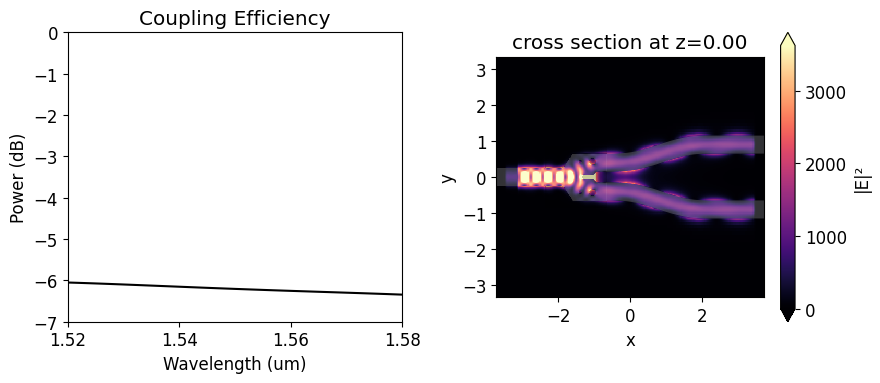

In [17]:
coeffs_f = sim_data["out_1"].amps.sel(direction="+")
power_1 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_1_db = 10 * np.log10(power_1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True)
ax1.plot(wl_range, power_1_db, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Power (dB)")
ax1.set_ylim(-7, 0)
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
ax1.set_title("Coupling Efficiency")
sim_data.plot_field("field_xy", "E", "abs^2", z=0, ax=ax2)
plt.show()

## Fabrication Constraints

Fabrication constraints are introduced in the optimization as penalty terms to control the minimum gap ($f_{g}$) and radius of curvature ($f_{c}$) in the final design. Below, we use `jax` to define the penalty terms following the formulation presented in `D. Vercruysse, N. V. Sapra, L. Su, R. Trivedi, and J. Vučković, "Analytical level set fabrication constraints for inverse design," Scientific Reports 9, 8999 (2019).` [DOI: 10.1038/s41598-019-45026-0](https://doi.org/10.1038/s41598-019-45026-0). The gap penalty function controls the minimum feature size by limiting the second derivative based on the value of the function at that point. The curvature constraint is only relevant at the device boundary, where $\phi = 0$, so we apply the smoothed Heaviside function to the level set surface before calculating the derivatives.

In [18]:
# Auxiliary function to calculate first and second order partial derivatives.
def ls_derivatives(phi, d_size):
    SC = 1e-12
    phi_1 = jnp.gradient(phi, d_size)
    phi_x = phi_1[0] + SC
    phi_y = phi_1[1] + SC
    phi_2x = jnp.gradient(phi_x, d_size)
    phi_2y = jnp.gradient(phi_y, d_size)
    phi_xx = phi_2x[0]
    phi_xy = phi_2x[1]
    phi_yy = phi_2y[1]
    return phi_x, phi_y, phi_xx, phi_xy, phi_yy    

# Minimum gap size fabrication constraint integrand calculation. 
# The "beta" parameter relax the constraint near the zero plane.
def fab_penalty_ls_gap(params, 
                       beta=1, 
                       min_feature_size=min_feature_size, 
                       grid_size=ls_grid_size):
    
    # Get the level set surface.
    phi_model = LevelSetInterp(x0=x_rho, y0=y_rho, z0=params, sigma=rho_size)
    phi = phi_model.get_ls(x1=x_phi, y1=y_phi)
    phi = jnp.reshape(phi, (nx_phi, ny_phi))
    
    # Calculates their derivatives.
    phi_x, phi_y, phi_xx, phi_xy, phi_yy = ls_derivatives(phi, grid_size)    

    # Calculates the gap penalty over the level set grid.
    pi_d = np.pi / (1.3 * min_feature_size)
    phi_v = jnp.maximum(jnp.power(phi_x ** 2 + phi_y ** 2, 0.5), jnp.power(1e-32, 1/4))
    phi_vv = (phi_x ** 2 * phi_xx + 2 * phi_x * phi_y * phi_xy + phi_y ** 2 * phi_yy) / phi_v ** 2                 
    return jnp.maximum((jnp.abs(phi_vv) / 
                      (pi_d * jnp.abs(phi) + beta * phi_v) - pi_d) , 0) * grid_size ** 2

# Minimum radius of curvature fabrication constraint integrand calculation.
# The "alpha" parameter controls its relative weight to the gap penalty.
# The "sharpness" parameter controls the smoothness of the surface near the zero-contour.
def fab_penalty_ls_curve(params, 
                         alpha=1,
                         sharpness = 1, 
                         min_feature_size=min_feature_size, 
                         grid_size=ls_grid_size):
    
    # Get the permittivity surface and calculates their derivatives.
    eps = get_eps(params, sharpness = sharpness)
    eps_x, eps_y, eps_xx, eps_xy, eps_yy = ls_derivatives(eps, grid_size) 

    # Calculates the curvature penalty over the permittivity grid.   
    pi_d = np.pi / (1.1 * min_feature_size)
    eps_v = jnp.maximum(jnp.sqrt(eps_x ** 2 + eps_y ** 2), jnp.power(1e-32, 1/6))
    k = (eps_x**2 * eps_yy - 2 * eps_x * eps_y * eps_xy + eps_y**2 * eps_xx) / eps_v**3
    curve_const = jnp.abs(k * jnp.arctan(eps_v / eps)) - pi_d
    return alpha * jnp.maximum(curve_const , 0) * grid_size ** 2

# Gap and curvature fabrication constraints calculation.
# Penalty values are normalized by "norm_gap" and "norm_curve".
def fab_penalty_ls(params, 
                   beta=gap_par, 
                   alpha=curve_par,
                   sharpness = 4,
                   min_feature_size=min_feature_size, 
                   grid_size=ls_grid_size,
                   norm_gap=1,
                   norm_curve=1):
    
    # Get the gap penalty fabrication constraint value.
    gap_penalty_int = fab_penalty_ls_gap(params=params, 
                                         beta=beta, 
                                         min_feature_size=min_feature_size, 
                                         grid_size=grid_size)
    gap_penalty = jnp.nansum(gap_penalty_int) / norm_gap

    # Get the curvature penalty fabrication constraint value.
    curve_penalty_int = fab_penalty_ls_curve(params=params, 
                                             alpha=alpha,
                                             sharpness=sharpness, 
                                             min_feature_size=min_feature_size, 
                                             grid_size=grid_size)
    curve_penalty = jnp.nansum(curve_penalty_int) / norm_curve
    
    return gap_penalty, curve_penalty

Now, we will calculate the initial penalty function values and observe the regions of the initial design that violate the constraints. The gap and curvature penalty functions are normalized by their initial values along the optimization to better balance the weights of device response and fabrication penalty within the objective function.

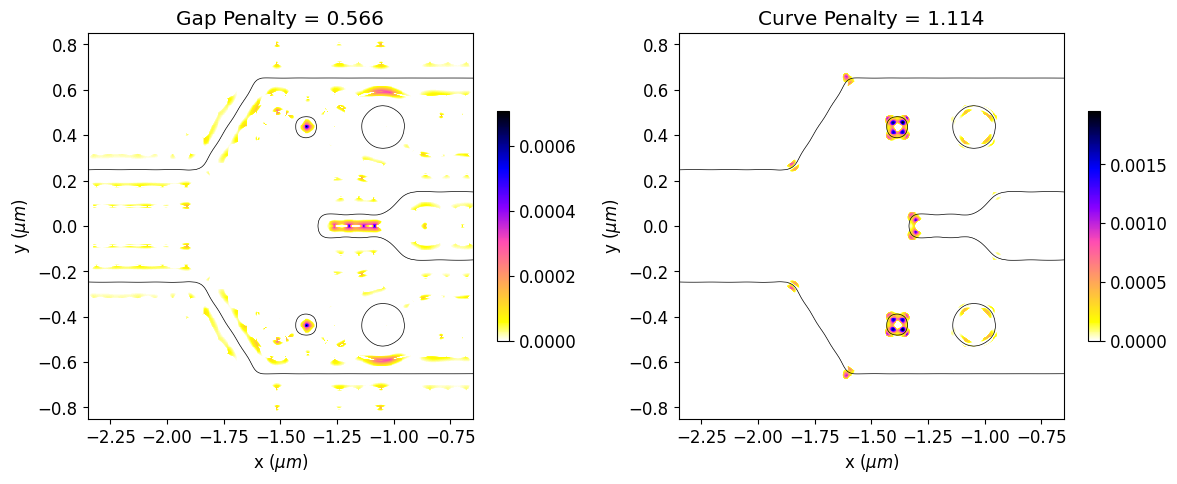

In [19]:
# Initial values of gap and curvature fabrication constraints.
init_fab_gap, init_fab_curve = fab_penalty_ls(mirror_param(init_rho))

# Visualization of gap and curvature fabrication constraints values.
gap_penalty_int = fab_penalty_ls_gap(mirror_param(init_rho), beta=gap_par)
curve_penalty_int = fab_penalty_ls_curve(mirror_param(init_rho), alpha=curve_par, sharpness=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
yy, xx = np.meshgrid(y_phi, x_phi)    

im = ax1.imshow(np.flipud(gap_penalty_int.T), extent=[x_phi[0], x_phi[-1], y_phi[0], y_phi[-1]], interpolation='none', cmap='gnuplot2_r')
ax1.contour(xx, yy, eps_fit, [(eps_min + eps_max) / 2], colors='k', linewidths=0.5)
ax1.set_title(f"Gap Penalty = {init_fab_gap:.3f}")   
ax1.set_xlabel("x ($\mu m$)")
ax1.set_ylabel("y ($\mu m$)")
fig.colorbar(im, ax = ax1, shrink = 0.3) 

im = ax2.imshow(jnp.flipud(curve_penalty_int.T), extent=[x_phi[0], x_phi[-1], y_phi[0], y_phi[-1]], interpolation='none', cmap='gnuplot2_r')
ax2.contour(xx, yy, eps_fit, [(eps_min + eps_max) / 2], colors='k', linewidths=0.5)
ax2.set_title(f"Curve Penalty = {init_fab_curve:.3f}")   
ax2.set_xlabel("x ($\mu m$)")
ax2.set_ylabel("y ($\mu m$)")
fig.colorbar(im, ax = ax2, shrink = 0.3)
plt.show()


## Running the Optimization

The figure-of-merit used in the y-branch optimization is the coupling efficiencies ($\eta_{1, 2}$) of the incident power into the fundamental transverse electric mode of the output waveguides. We will set mirror symmetry about the `y`-axis in the optimization, so we must include only $\eta_{1}$ in the figure-of-merit. As we are using a minimization strategy, the coupling efficiency and fabrication constraints are arranged within the objective function as $|0.5 - \eta_{1}| + w_{f} \times (f_{g} + f_{c})$, where $w_{f}$ is the fabrication constraint weight, whereas $f_{g}$ and $f_{c}$ are the gap and curvature penalty values.

In [20]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: tda.JaxSimulationData) -> float:
    """Return the power at the mode index of interest."""
    output_amps1 = sim_data.output_data[0].amps
    amp1 = output_amps1.sel(direction="+", f=freq, mode_index=0)
    eta1 = jnp.sum(jnp.abs(amp1)) ** 2
    return jnp.abs(0.5 - eta1), eta1

# Objective function to be passed to the optimization algorithm.
def obj(design_param, fab_const: float = 0.0, norm_gap=1.0, norm_curve=1.0, verbose: bool = False) -> float:
    param = mirror_param(design_param)
    sim = make_adjoint_sim(param)
    sim_data = run(sim, task_name="inv_des_ybranch", verbose=verbose)
    fom_val, eta1 = fom(sim_data)
    fab_gap, fab_curve = fab_penalty_ls(param, norm_gap=norm_gap, norm_curve=norm_curve)    
    J = fom_val + fab_const * (fab_gap + fab_curve)    
    return J, [sim_data, eta1, fab_gap, fab_curve]

# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad = value_and_grad(obj, has_aux=True)

Optimizer initialization

In [21]:
# where to store history
history_fname = "./misc/y_branch_fab.pkl"

def save_history(history_dict: dict) -> None:
    """Convenience function to save the history to file."""
    with open(history_fname, "wb") as file:
        pickle.dump(history_dict, file)


def load_history() -> dict:
    """Convenience method to load the history from file."""
    with open(history_fname, "rb") as file:
        history_dict = pickle.load(file)
    return history_dict

Before starting, we will look for data from a previous optimization.

In [22]:
# Initialize adam optimizer with starting parameters.
optimizer = optax.adam(learning_rate=learning_rate*8)

try:
    history_dict = load_history()
    opt_state = history_dict["opt_states"][-1]
    params = history_dict["params"][-1]
    num_iters_completed = len(history_dict["params"])
    print("Loaded optimization checkpoint from file.")
    print(
        f"Found {num_iters_completed} iterations previously completed out of {iterations} total."
    )
    if num_iters_completed < iterations:
        print(f"Will resume optimization.")
    else:
        print("Optimization completed, will return results.")

except FileNotFoundError:
    params = np.array(init_rho)
    opt_state = optimizer.init(params)
    history_dict = dict(
        values=[],
        eta1=[],
        penalty_gap=[],
        penalty_curve=[],
        params=[],
        gradients=[],
        opt_states=[opt_state],
        data=[],
    )

Loaded optimization checkpoint from file.
Found 100 iterations previously completed out of 100 total.
Optimization completed, will return results.


Now, we are ready to run the optimization!

In [23]:
td.config.logging_level = "ERROR"

iter_done = len(history_dict["values"])

if iter_done < iterations:
    for i in range(iter_done, iterations):

        # Compute gradient and current objective funciton value.
        (value, data), gradient = obj_grad(params, fab_const=0.05, norm_gap=init_fab_gap, norm_curve=init_fab_curve)
        sim_data_i, eta1, penalty_gap, penalty_curve = data
        
        # outputs
        print(f"Step = {i + 1}")
        print(f"\tobj_val = {value:.4e}")
        print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")
        print(f"\teta1 = {eta1:.3f}")
        print(f"\tpenalty gap = {penalty_gap:.3f}")
        print(f"\tpenalty curve = {penalty_curve:.3f}")

        # Compute and apply updates to the optimizer based on gradient.
        updates, opt_state = optimizer.update(gradient, opt_state, params)
        params = optax.apply_updates(params, updates)

        # Save history.
        history_dict["values"].append(value)
        history_dict["eta1"].append(eta1)
        history_dict["penalty_gap"].append(penalty_gap)
        history_dict["penalty_curve"].append(penalty_curve)                
        history_dict["params"].append(params)
        history_dict["gradients"].append(gradient)
        history_dict["opt_states"].append(opt_state)
        # history_dict["data"].append(sim_data_i)  # Uncomment to store data, can create large files.
        save_history(history_dict)

In [24]:
obj_vals = np.array(history_dict["values"])
eta1_vals = np.array(history_dict["eta1"])
pen_gap_vals = np.array(history_dict["penalty_gap"])
pen_curve_vals = np.array(history_dict["penalty_curve"])
final_par = history_dict["params"][-1]

### Optimization Results

Below, we can see how the device response and fabrication penalty have evolved throughout the optimization. The coupling into the output waveguide improves fast in the beginning at the expense of higher penalty values. Then, the penalty values decrease linearly after the device response achieves a near-optimal condition. This trend results from the small weight factor we have chosen for the fabrication penalty terms. 

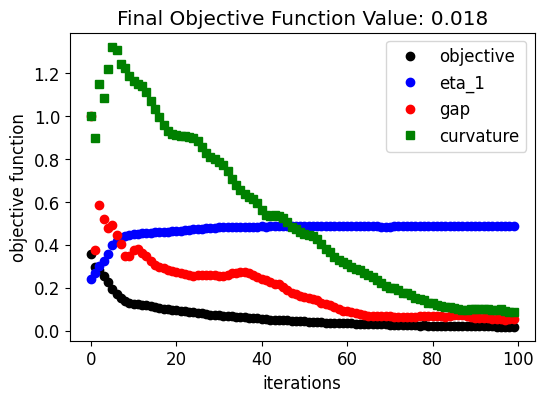

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals, "ko", label="objective")
ax.plot(eta1_vals, "bo", label="eta_1")
ax.plot(pen_gap_vals, "ro", label="gap")
ax.plot(pen_curve_vals, "gs", label="curvature")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.legend()
ax.set_title(f"Final Objective Function Value: {obj_vals[-1]:.3f}")
plt.show()

The optimization process obtained a smooth and well-defined geometry. 

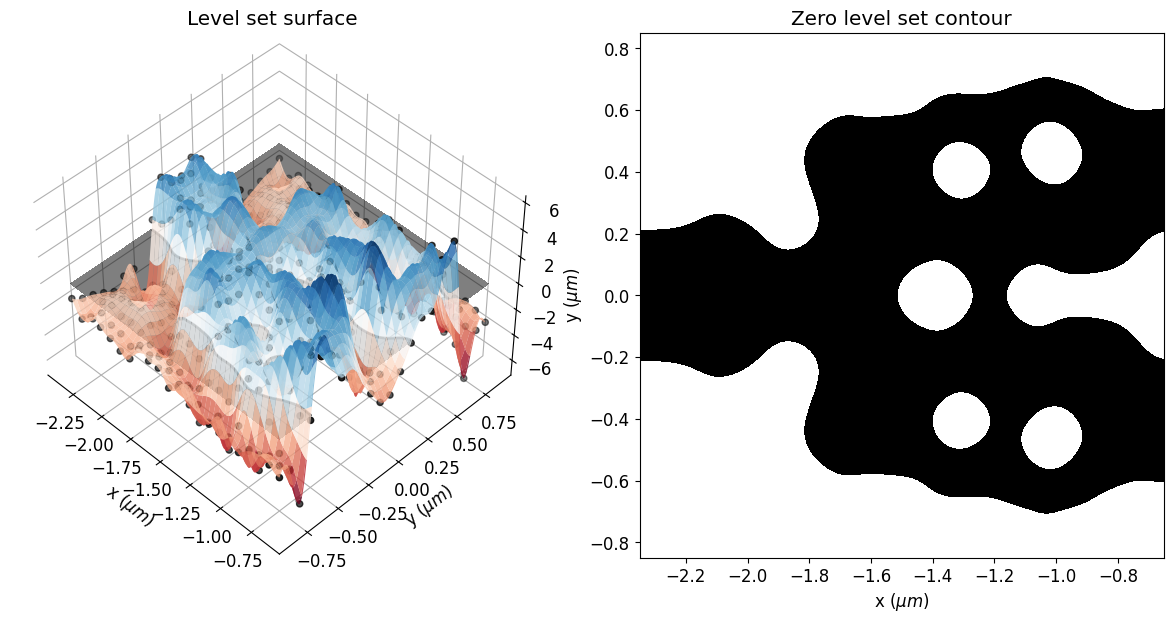

In [26]:
eps_final = get_eps(mirror_param(final_par), plot_levelset=True)

We can also see a significant reduction in violations to the minimum feature size after the optimization, which results in a smoother structure. The optimized device has not matched the minimum feature size exactly. The minimum radius of curvature and gap size are about 30% higher and 20% lower than the reference feature size, respectively. This deviation is expected, as reported in the previous paper. In this regard, running the simulation longer, adjusting the penalty weight or compensating for the reference feature size could improve the results.

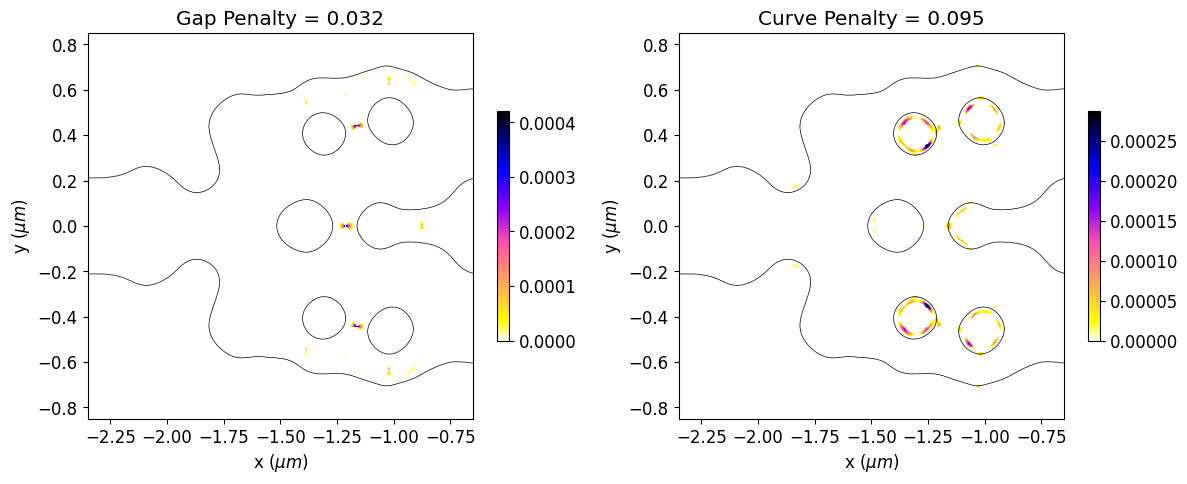

In [27]:
# Initial values of gap and curvature fabrication constraints.
final_fab_gap, final_fab_curve = fab_penalty_ls(mirror_param(final_par))

# Visualization of gap and curvature fabrication constraints values.
gap_penalty_int = fab_penalty_ls_gap(mirror_param(final_par), beta=gap_par)
curve_penalty_int = fab_penalty_ls_curve(mirror_param(final_par), alpha=curve_par, sharpness=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
yy, xx = np.meshgrid(y_phi, x_phi)    

im = ax1.imshow(np.flipud(gap_penalty_int.T), extent=[x_phi[0], x_phi[-1], y_phi[0], y_phi[-1]], interpolation='none', cmap='gnuplot2_r')
ax1.contour(xx, yy, eps_final, [(eps_min + eps_max) / 2], colors='k', linewidths=0.5)
ax1.set_title(f"Gap Penalty = {final_fab_gap:.3f}")   
ax1.set_xlabel("x ($\mu m$)")
ax1.set_ylabel("y ($\mu m$)")
fig.colorbar(im, ax = ax1, shrink = 0.3) 

im = ax2.imshow(jnp.flipud(curve_penalty_int.T), extent=[x_phi[0], x_phi[-1], y_phi[0], y_phi[-1]], interpolation='none', cmap='gnuplot2_r')
ax2.contour(xx, yy, eps_final, [(eps_min + eps_max) / 2], colors='k', linewidths=0.5)
ax2.set_title(f"Curve Penalty = {final_fab_curve:.3f}")   
ax2.set_xlabel("x ($\mu m$)")
ax2.set_ylabel("y ($\mu m$)")
fig.colorbar(im, ax = ax2, shrink = 0.3)
plt.show()

Once the inverse design is complete, we can visualize the field distributions and the wavelength dependent coupling efficiencies.

In [28]:
sim_final = make_adjoint_sim(mirror_param(final_par), unfold=True)
sim_final = sim_final.to_simulation()[0].copy(update=dict(monitors=(field_xy, fom_final_1)))
sim_data_final = web.run(sim_final, task_name="inv_des_final")

16:09:23 -03 Created task 'inv_des_final' with task_id                          
             'fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=115592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=328717;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\taskId]8;;\]8;id=115592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\=]8;;\]8;id=35753;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\fdve]8;;\]8;id=115592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\-8cdff799-a80]8;;\
             ]8;id=115592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\3-4b09-b333-ca0fc4f4e1dc']8;;\.

Output()

16:09:30 -03 status = queued

Output()

16:09:40 -03 status = preprocess

16:09:48 -03 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:10:10 -03 early shutoff detected at 96%, exiting.

             status = postprocess

Output()

16:10:16 -03 status = success

             View simulation result at                                          
             ]8;id=708059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=514744;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\taskId]8;;\]8;id=708059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\=]8;;\]8;id=103877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\fdve]8;;\]8;id=708059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\-8cdff799-a80]8;;\
             ]8;id=708059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8cdff799-a803-4b09-b333-ca0fc4f4e1dc\3-4b09-b333-ca0fc4f4e1dc']8;;\.

Output()

16:10:31 -03 loading simulation from simulation_data.hdf5

The resulting structure shows good performance, presenting coupling efficiencies close to -3 dB at the central wavelength.

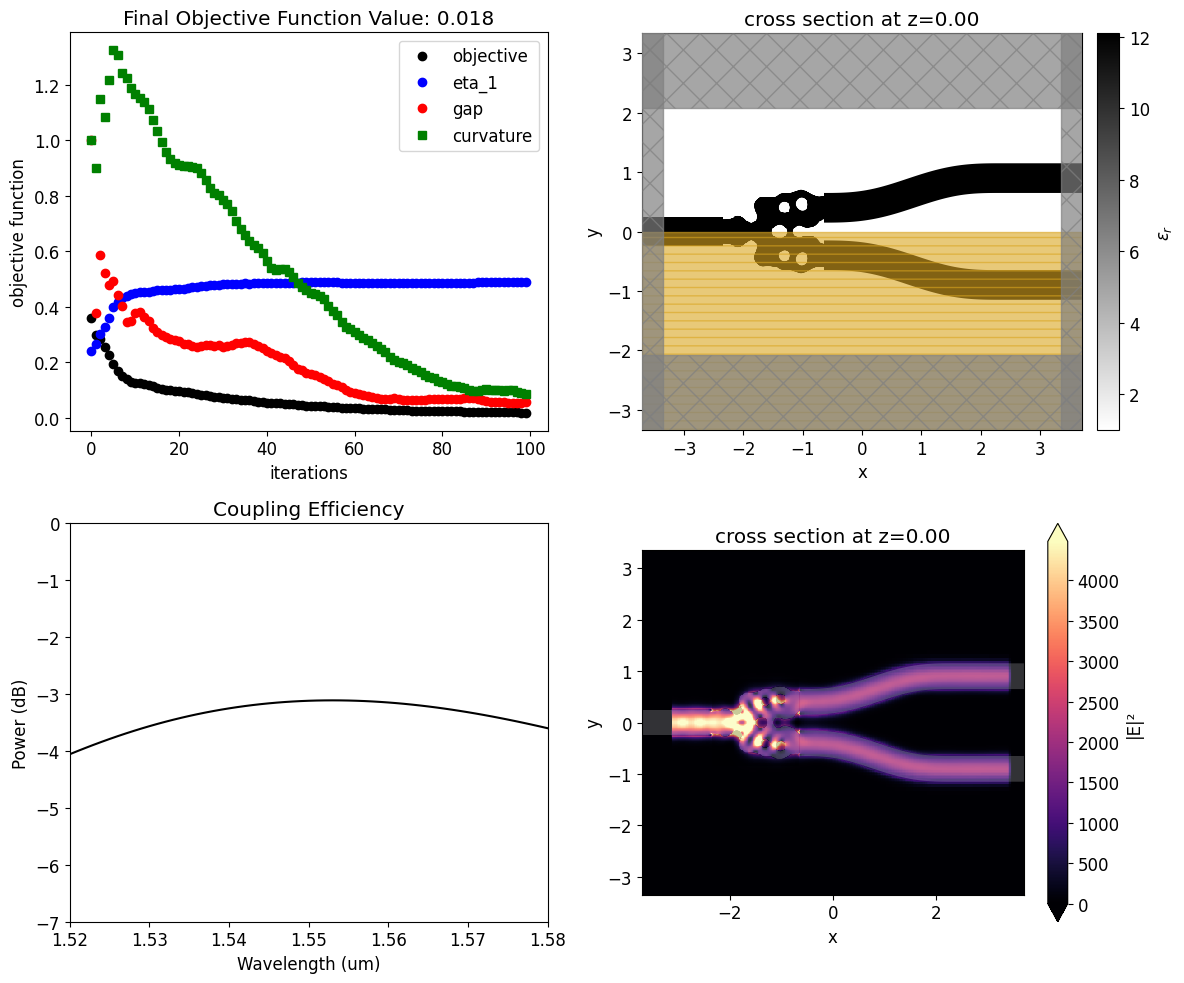

In [29]:
mode_amps = sim_data_final["out_1"]
coeffs_f = mode_amps.amps.sel(direction="+")
power_1 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_1_db = 10 * np.log10(power_1)

f, ax = plt.subplots(2, 2, figsize=(12, 10), tight_layout=True)
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax[0, 1])
ax[1, 0].plot(wl_range, power_1_db, "-k")
ax[1, 0].set_xlabel("Wavelength (um)")
ax[1, 0].set_ylabel("Power (dB)")
ax[1, 0].set_ylim(-7, 0)
ax[1, 0].set_xlim(wl - bw / 2, wl + bw / 2)
ax[1, 0].set_title("Coupling Efficiency")
sim_data_final.plot_field("field_xy", "E", "abs^2", z=0, ax=ax[1, 1])
ax[0, 0].plot(obj_vals, "ko", label="objective")
ax[0, 0].plot(eta1_vals, "bo", label="eta_1")
ax[0, 0].plot(pen_gap_vals, "ro", label="gap")
ax[0, 0].plot(pen_curve_vals, "gs", label="curvature")
ax[0, 0].set_xlabel("iterations")
ax[0, 0].set_ylabel("objective function")
ax[0, 0].legend()
ax[0, 0].set_title(f"Final Objective Function Value: {obj_vals[-1]:.3f}")
plt.show()